In [1]:
torch.Tensor{1,2,3}

 1
 2
 3
[torch.DoubleTensor of size 3]



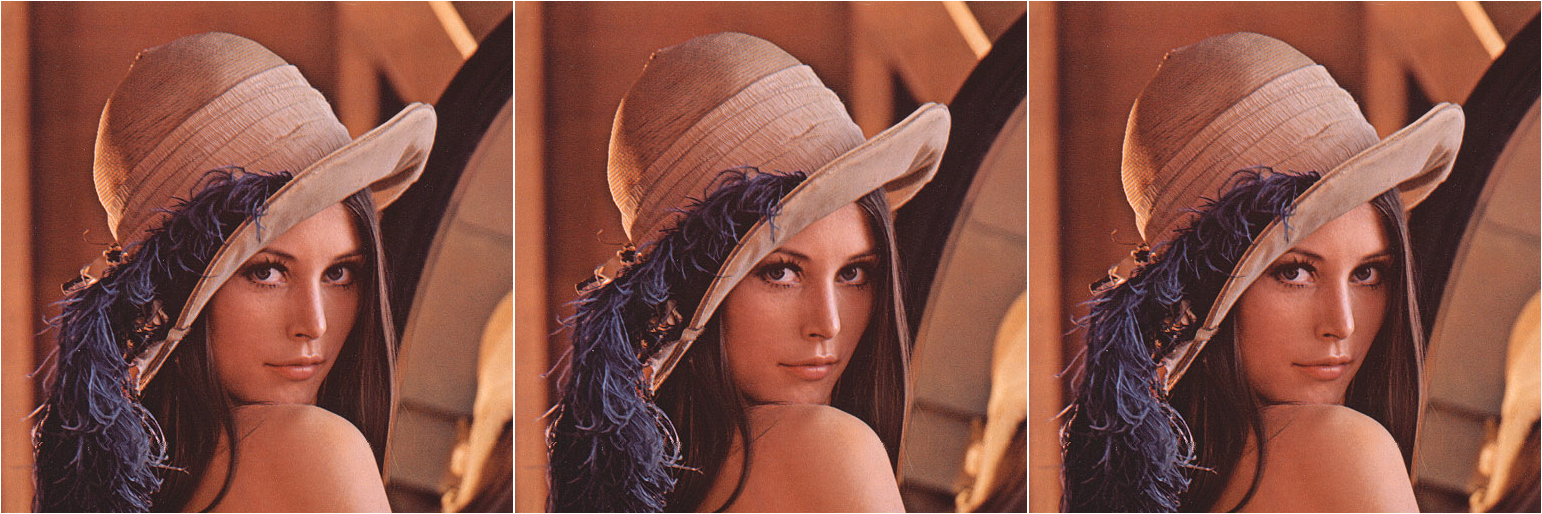

In [1]:
require 'image';
itorch.image({image.lena(), image.lena(), image.lena()})

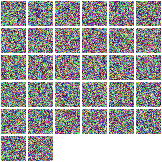

In [2]:
require 'nn'
m=nn.SpatialConvolution(3,32,25,25)
itorch.image(m.weight)

In [10]:
-- Max Jaderberg 4/9/13
-- GPU Effectiveness test

require 'cltorch'
require 'sys'
require 'clnn'
require 'xlua'

cmd = torch.CmdLine()
cmd:text()
cmd:text('GPU Benchmark. Max Jaderberg.')
cmd:text()
cmd:text('Options:')
cmd:option('-size', 24, 'size of images')
cmd:option('-N', 1000, 'number of images')
cmd:option('-threads', 2, 'number of threads')
cmd:text()
opt = cmd:parse(arg or {})
cltorch.setDevice(1)

torch.setnumthreads(opt.threads)

torch.setdefaulttensortype("torch.FloatTensor")

-- Input size
sz = opt.size
finalsize = (sz - 4)/2 --for a 5x5 filter
Ntest = opt.N

-- Test input
x = torch.rand(Ntest, 24, sz, sz)

-- Simple network
model = nn.Sequential()
model:add(nn.SpatialConvolution(24, 512, 5, 5))
model:add(nn.Tanh())
model:add(nn.SpatialLPPooling(512, 2, 2, 2, 2, 2))
model:add(nn.Reshape(512*finalsize*finalsize))
model:add(nn.Linear(512*finalsize*finalsize, 512))
model:add(nn.Tanh())
model:add(nn.Linear(512, 2))
model:add(nn.Tanh())
criterion = nn.MSECriterion()

-- Test ouput
y = torch.rand(Ntest, 2)


-- Test routine
local runtest = function() 
  print('==> Type is '..x:type())

	for i = 1,x:size(1) do
		xlua.progress(i, x:size(1))

		local yp = model:forward(x[i])
		local err = criterion:forward(yp, y[i])
		local df_do = criterion:backward(yp, y[i])
		model:backward(x[i], df_do)
	end
end


-- CPU TEST
cputime0 = sys.clock()
runtest()
cputime1 = sys.clock()
cputime = cputime1 - cputime0
print('CPU Time: '.. (cputime*1000) .. 'ms')

-- GPU TEST
require 'clnn'
x = x:cl()
y = y:cl()
model:cl()
criterion:cl()

gputime0 = sys.clock()
runtest()
gputime1 = sys.clock()
gputime = gputime1 - gputime0
print('GPU Time: '.. (gputime*1000) .. 'ms')

print('------------------')
print('GPU speedup: '..cputime/gputime..'x')







==> Type is torch.FloatTensor	


Progress: 207 / 1000	


Progress: 426 / 1000	


Progress: 643 / 1000	


Progress: 858 / 1000	


CPU Time: 36269.066095352ms	


==> Type is torch.ClTensor	


GPU Time: 10263.864994049ms	
------------------	
GPU speedup: 3.533665545716x	
